### All-sky AME vs. IR Scatter Plots

In [3]:
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpy.projector as pro
import astropy.io.fits as fits
from scipy.stats import gaussian_kde
import scipy
import pandas as pd
import pickle
matplotlib.style.use('seaborn-bright')
%matplotlib inline

# 0.1) Load data and masks:

In [6]:
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw,  phot, phot_modesub, phot_mpsub = pickle.load(f)
    



ValueError: need more than 5 values to unpack

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


### Setup the standard pipeline to apply to all the data:
allsky_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler(with_mean=False)),
])
# allsky_pipeline = Pipeline([
#     ('imputer', Imputer(strategy="median"))
# ])

phot_tr      = pd.DataFrame(allsky_pipeline.fit_transform(phot),columns=phot.columns)
planck_bb_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_bb),columns=planck_bb.columns)
planck_mw_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_mw),columns=planck_mw.columns)




In [4]:
planck_bb.head()

,$T$,$B$,$I_{dust}(545)$,$R_{PR1}$,"$ au_{353,PR1}$",$U$
0,20.623632,1.623271,8408.021484,0.000040,0.000469,0.085086
1,20.487495,1.626371,7957.707520,0.000019,0.000369,0.052552
2,20.490595,1.615768,7821.354004,0.000014,0.000381,0.037848
3,20.232548,1.624258,7113.281738,0.000012,0.000321,0.036052
4,20.237684,1.629054,7348.119141,0.000014,0.000358,0.038079


### 1.1) Cross-correlation among all IR photometric bands and AME map
##### Split by Galactic Latitude

In [5]:
glatrange     = 10.0
elatrange     = 5


gcut_l = np.where(
    (abs(coords['glat']) < glatrange) & 
    (abs(coords['elat']) > elatrange)
    )

gcut_h = np.where(
    (abs(coords['glat']) > glatrange) & 
    (abs(coords['elat']) > elatrange)
)



In [6]:
import seaborn as sb


In [26]:
def plotCorrMatrix(mapframe, pdf_suffix):
    
    mapframe_corr     = mapframe.corr(method='spearman')
    mapframe_corr_lgl = mapframe.iloc[gcut_l].corr(method='spearman')
    
    mask = np.zeros_like(mapframe_corr.values)
    mask[np.triu_indices_from(mask,k=1)] = True

    with sb.axes_style("white"):


        fig, ax = plt.subplots(1,2,figsize=(14,7))
        cbar_ax = fig.add_axes([.91, .2, .03, .7])

        sb.heatmap(
            mapframe_corr,
            #linewidths=.5,
            annot=True,
            mask=mask,
            cbar=False,
            yticklabels=True,
            xticklabels=True,
            ax = ax[0],
            vmin=0,
            vmax=1)

        ax[0].set_title("Whole-sky", fontsize=20)

        sb.heatmap(
            mapframe_corr_lgl,
            #linewidths=.5,
            annot=True,
            mask=mask,
            cbar=True,
            cbar_ax=cbar_ax,
            yticklabels=True,
            xticklabels=True,
            ax=ax[1],
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'Spearman $r$'})

        ax[1].set_title("$|b| < 10^{\circ}$", fontsize=20)

        #cbar_ax.set_title("Spearman $r$")
        fig.tight_layout(rect=[0, 0, .9, 1])

        plt.show()

        fig.savefig("../Plots/all_bands_corr_matrix_wAME_spearman{}.pdf".format(pdf_suffix), bbox_inches='tight')
        


Now we compare the spearman correlation scores among all of the IR bands, and the AME. We do this for for 3 different cases: 

  * Intensity
  * Intensity / U
  * Intensity / R 

In [27]:
# Cross-correlation: Intensity vs. AME and Dust Radiance

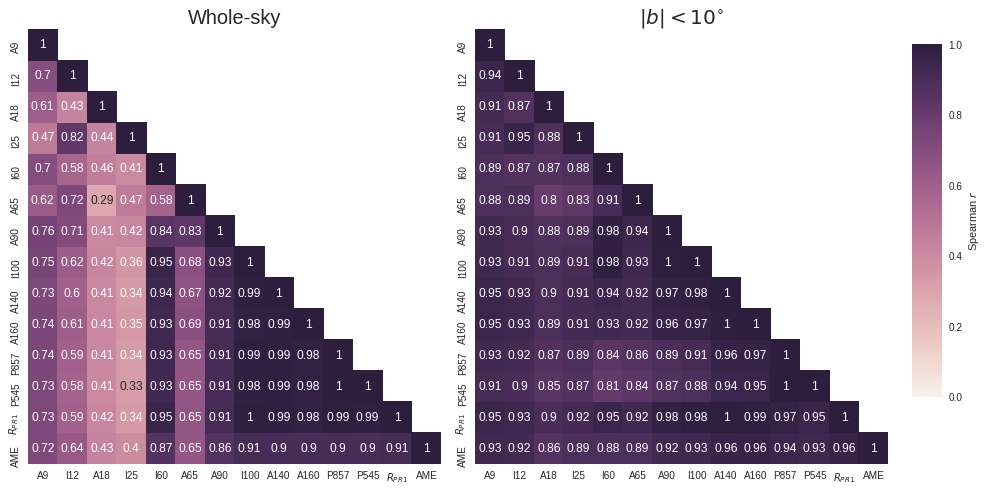

In [32]:
plotCorrMatrix(
    phot_mpsub.join(
        planck_bb['$R_{PR1}$']).join(planck_mw['AME']
                ),
    pdf_suffix = 'intensity'
               )

#### Cross-correlation: MIR/U Bands vs. AME/U and R/U

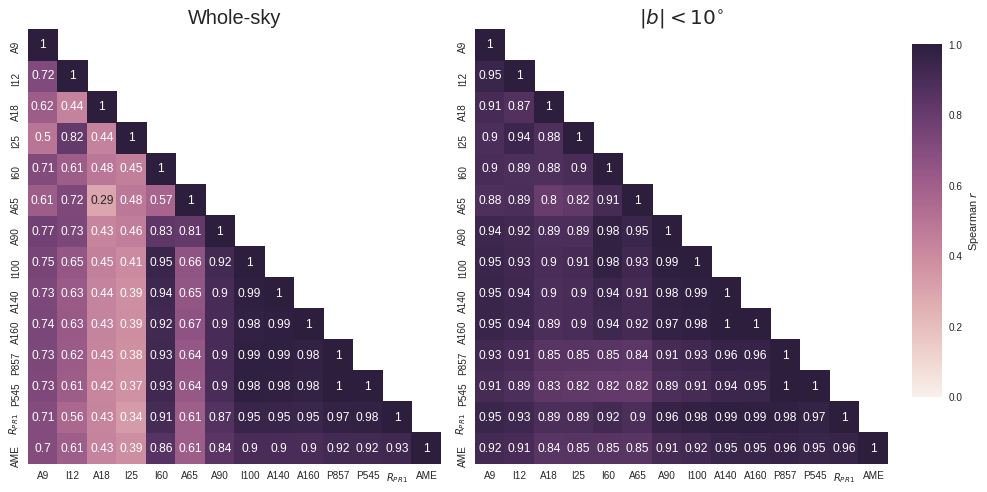

In [31]:
plotCorrMatrix(  
                (
                    phot_mpsub.join(
                    planck_bb['$R_{PR1}$']).join(
                        planck_mw['AME'])
                ).divide(
                    planck_bb['$U$'], axis=0),
                pdf_suffix = 'U_norm'
               )

### 1.2) Cross-correlation among all IR photometric bands and AME map
##### Split by AKARI 9 micron detection limit (2 MJy/sr)

In [9]:
def maskByIntensity(cutoff_map, lower_cutoff=5.0, upper_cutoff = 5e2):
    
    cutoff_map_cp = cutoff_map.copy()

    lim = np.where(
        (cutoff_map > lower_cutoff ) & 
        (cutoff_map < upper_cutoff)
        )
    
    return lim


def plotCorrMatrixwCutoff(mapframe,
                          cutoff_map,
                          lower_cutoff = 5.0, 
                          upper_cutoff = 5e2):
    
    cutoff_map_cp = cutoff_map.copy()

    cutoff = np.where(
        (cutoff_map > lower_cutoff) & 
        (cutoff_map < upper_cutoff)
        )
    
    
    mapframe_corr        = mapframe.corr(method='spearman')
    mapframe_corr_masked = mapframe.iloc[cutoff].corr(method='spearman')
    
    #bb_corr_drop = bb_corr.drop('AME',axis=0).drop('A9',axis=1)
    mask = np.zeros_like(mapframe_corr.values)
    mask[np.triu_indices_from(mask,k=1)] = True

    with sb.axes_style("white"):


        fig, ax = plt.subplots(1,2,figsize=(15,7.5))
        cbar_ax = fig.add_axes([.91, .2, .03, .7])

        sb.heatmap(
            mapframe_corr,
            #linewidths=.5,
            annot=True,
            mask=mask,
            cbar=False,
            yticklabels=True,
            xticklabels=True,
            ax = ax[0],
            vmin=0,
            vmax=1)

        ax[0].set_title("All-sky", fontsize=20)


        sb.heatmap(
            mapframe_corr_masked,
            #linewidths=.5,
            annot=True,
            mask=mask,
            cbar=True,
            cbar_ax = cbar_ax,
            yticklabels=True,
            xticklabels=True,
            ax=ax[1],
            vmin=0,
            vmax=1)

        ax[1].set_title("{} > $I_um$ > {} MJy/sr".format(upper_cutoff,lower_cutoff), fontsize=20)


        fig.tight_layout(rect=[0, 0, .9, 1])

        plt.show()

        fig.savefig("../Plots/all_bands_corr_matrix_wAME__IRC9lim{}_{}_MJysr_spearman.pdf".format(
                upper_cutoff,lower_cutoff), bbox_inches='tight')

        cutoff_map_cp.iloc[:] = hp.UNSEEN
        cutoff_map_cp.iloc[cutoff] = cutoff_map.iloc[cutoff].copy()
        
        hp.mollview(cutoff_map_cp, nest=True, norm='hist', cmap="rainbow")

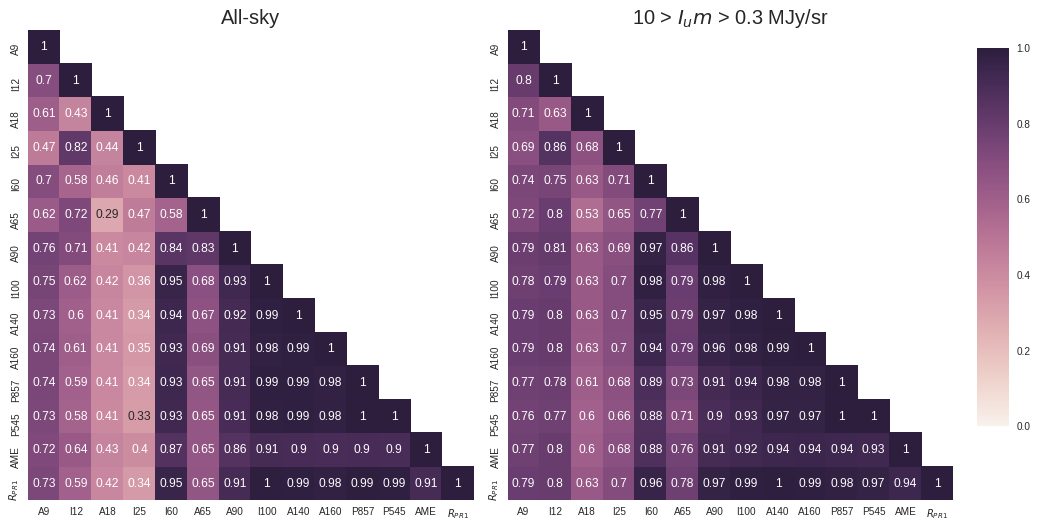

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/healpy/projaxes.py:859: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[np.isinf(val.data)] = -np.inf


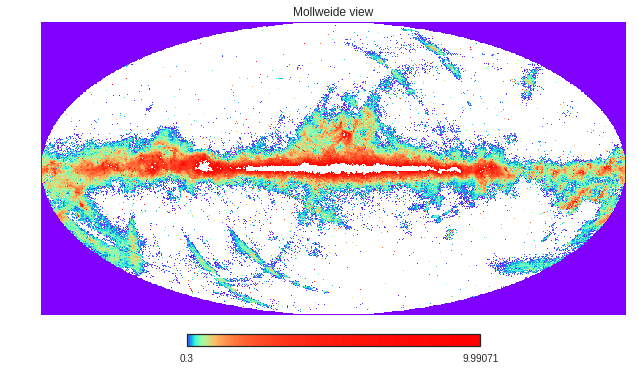

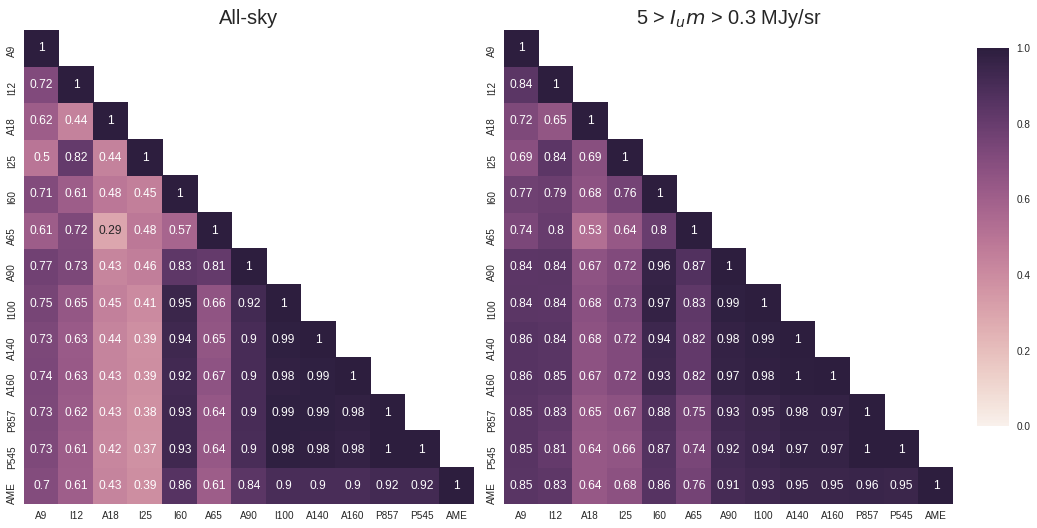

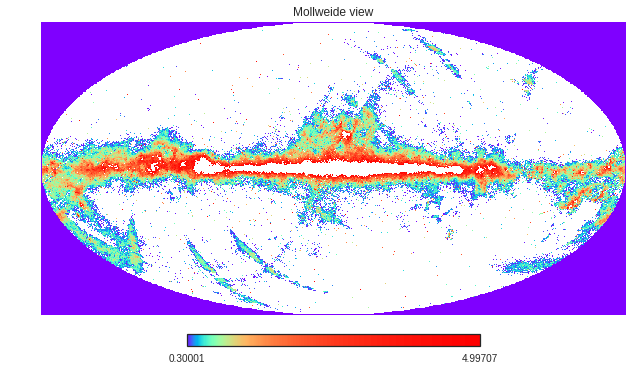

In [10]:
plotCorrMatrixwCutoff(
                        phot_mpsub.join(planck_mw['AME']).join(planck_bb['$R_{PR1}$']), 
                        phot_modesub['A9'], 
                        lower_cutoff=0.3, 
                        upper_cutoff = 10) 

plotCorrMatrixwCutoff(
                        phot_mpsub.join(planck_mw['AME']).divide(planck_bb['$U$'], axis=0), 
                        phot_mpsub['A9'], 
                        lower_cutoff=0.3, 
                        upper_cutoff = 5)

Why is IRAS 25 $\mu$m the most unique map? Somewhat odd that it correlates miraculously well with IRAS 12 $\mu$m - despite its weak correlation with  the IRC $\mu$m map. Perhaps this is due to correlated noise, systematic effects in the IRAS MIR bands. Correlated Zodiacal light subtraction residuals, perhaps

# All-sky AME vs. IR plots:

In [34]:
def plotBandsCloud(xframe, yseries, xlabel, ylabel, xylims, outpath, nside=256):
    
    sb.set_style("whitegrid")

    ncols=4
    nrows=3
    aspect=1.0

    fig, axs = plt.subplots(ncols=ncols, 
                            nrows=nrows, 
                            sharey=True, 
                            sharex=True)
    #fig.subplots_adjust(hspace=0.1, left=0.1, right=0.7)
    plt.setp(axs.flat, aspect=1.0, adjustable='box-forced')

    k=0

    hsize = hp.nside2npix(nside)
    
    randsub = np.random.randint(low=0, high=hsize, size=hsize//50)


    for i in range(0,nrows):
        for j in range(0,ncols):
                
                #print k
                
                if k > 11:

                    pass

                else:

                    x = xframe[xframe.columns[k]].iloc[randsub]


                    y = yseries.iloc[randsub]

                    x_ = x[(x>0) & (y>0) & (np.isfinite(x)==True) & (np.isfinite(y)==True)].copy()
                    y_ = y[(x>0) & (y>0) & (np.isfinite(x)==True) & (np.isfinite(y)==True)].copy()

                    x_ = np.log10(x_).values
                    y_ = np.log10(y_).values

                    ax = axs[i,j]

                    sb.kdeplot(
                           x_,
                           y_,
                           shade=True,
                           shade_lowest=False,
                           gridsize=100,
                            ax = ax)



                    #ax.axis([xmin, xmax, ymin, ymax])
                    ax.axis(xylims)

                    ax.text(0.2, 0.9,xframe.columns[k], horizontalalignment='center',
                      verticalalignment='center',
                      transform=ax.transAxes, 
                      fontsize=15)

                    ax.grid(True)

                    ax.set_frame_on(True)

                    k += 1
                    
        ax = axs[-1,0]
        ax.set_ylabel(ylabel, fontsize=15)
        ax = axs[-1,0]
        ax.set_xlabel(xlabel, fontsize=15)

        plt.show()

        fig.savefig(outpath, bbox_inches='tight')
        fig.savefig(outpath[:-4]+".png", bbox_inches='tight')

                    
    return axs
    


In [ ]:
axs = plotBandsCloud(
                xframe = phot_mpsub, 
               yseries = planck_mw['AME'],
                ylabel = 'log $I_{AME}$ [$\mu{}K_{CMB}$]',
                xlabel = 'log $I_{\lambda}$ [MJy/sr]',
                xylims = [-1.5,2,1,3.5],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub_kde.pdf"
)

In [ ]:
axs = plotBandsCloud(
                xframe = phot_mpsub, 
               yseries = planck_mw['AME'].divide(planck_bb['$U$'], axis=0),
                ylabel = 'log $I_{AME}$ /$U$ [$\mu{}K_{CMB}$]',
                xlabel = 'log $I_{\lambda}$ [MJy/sr]',
                xylims = [-1.5,2,2.5,5.5],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub__AMEUNorm_kde.pdf"
)

In [ ]:
axs = plotBandsCloud(
                xframe = phot_mpsub.divide(planck_bb['$U$'], axis=0), 
               yseries = planck_mw['AME'].divide(planck_bb['$U$'], axis=0),
                ylabel = 'log $I_{AME}$ / $U$ [$\mu{}K_{CMB}$]',
                xlabel = 'log $I_{\lambda}$ / $U$[MJy/sr]',
                xylims = [-1.5,3,2.5,5.5],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub__UNorm_kde.pdf"
)

In [ ]:
## Check correlations, adding 10% noise after removal of first principal component

### Cross correlation between AME and Planck Mod-BB fits 
(+the smoothed PR1 Radiance map, as used by Hensley+ 2016)

## Confirmation of all-sky correlation results:
 Instead of downgrading the pixel sizes, just copy the same correaltion value of the 64 NSIDE 256 pixels
 in a batch to all of those pixel positions in an output map (also size NSIDE 256).

In [16]:
from notebook.nbextensions import check_nbextension
check_nbextension('codefolding', user=True)
check_nbextension('codefolding/main.js', user=True)

False

In [ ]:
def testSpatialCorr(df, 
                    nside_in, 
                    nside_out,
                    method='spearman'):
    
    npix_in    = 12*nside_in**2
    npix_out   = 12*nside_out**2
    pix_interv = (nside_in/nside_out)**2
    
    ## First, do it the "normal way"-
    patches_corr = [df.iloc[i*pix_interv:(i+1)*pix_interv].corr(method=method) for i in range(0,npix_out)]
    corr_patches_pn = pd.Panel({i: patches_corr[i] for i in range(0,npix_out)})

    
    return corr_patches_pn

def displaySpatialCorr(corr_patches_pn,labels, ref_col=0,subdir='../Plots/Allsky_Corr/'):

    nside = len(corr_patches_pn.values[:,0,0])
    #fig = plt.figure(figsize=(8,4))

    for j in range(0,len(labels)):
        #plt.subplot(2,5,(j*2)+1)
        hp.mollview(corr_patches_pn.values[:,j,ref_col],
                         #sub=(1,4,j+1), 
                         #fig=fig,
                         cmap = "rainbow", 
                         cbar = False, 
                         min  = -1, 
                         max  = 1, 
                         nest = True, 
                         title="$S$({}:{}) NSIDE".format(labels[ref_col],labels[j],nside_out))
        hp.graticule(dpar=5, dmer=5,coord='G')
        
        plt.savefig("{}/Spearman_Map_nside{}_{}to{}.pdf".format(subdir,nside_out,labels[ref_col],labels[j]) )

In [ ]:
for i in range(0,len(test_frame.columns)):
    displaySpatialCorr(corr_patches_pn, test_frame.columns, ref_col = i)

In [ ]:
nside_in = 256
nside_out = 8
test_frame_RadNorm = phot_mpsub.join(planck_mw['AME']).divide(planck_bb['$R_{PR1}$'], axis=0)
corr_patches_pn_RadNorm = testSpatialCorr(test_frame_RadNorm,
                                  nside_in, 
                                  nside_out)

In [ ]:
for i in range(0,len(test_frame_RadNorm.columns)):
    displaySpatialCorr(corr_patches_pn_RadNorm, test_frame_RadNorm.columns, ref_col = i,
                                  subdir='../Plots/Allsky_Corr/UNorm')

In [ ]:
nside_in = 256
nside_out = 8
test_frame_UNorm = phot_mpsub.join(planck_mw['AME']).divide(planck_bb['$U$'], axis=0),
corr_patches_pn_UNorm = testSpatialCorr(test_frame_UNorm,
                                  nside_in, 
                                  nside_out)

In [ ]:
for i in range(0,len(test_frame_UNorm.columns)):
    displaySpatialCorr(corr_patches_pn_UNorm, test_frame_UNorm.columns, ref_col = i,
                                  subdir='../Plots/Allsky_Corr/UNorm')

In [8]:
phot_mpsub.head()

NameError: name 'phot_mpsub' is not defined

In [7]:
# All-sky Ionization fraction:
phot_mir_ratios = phot_mpsub.drop(['A9']).join(planck_bb['$R_{PR1}$']).join(planck_mw['$R_{PR1}$']).divide(phot_mpsub.A9)
   

NameError: name 'phot_mpsub' is not defined

In [ ]:
# The check appears successful, so make a plot grid of all the nsides:

## All-sky Noise Estimation:

In [ ]:
hmap_hists =  pd.DataFrame.hist(phot_modesub, 
                                range=(-10, 25), 
                                bins=100, 
                                alpha=0.4, 
                                grid=True,
                                sharex=True, 
                                xlabelsize=15,
                                sharey=False,
                                ylabelsize=12,
                                figsize=(11,8.5),
                                **{'normed':True})
hmap_hists

In [ ]:
def plot_hdists(df):
    
    import seaborn as sns
    import scipy.stats as stats
    sns.distplot(df, bins=1000, kde=False, fit=stats.gamma )
    print 
    
plot_hdists(phot_modesub[(phot_modesub>-5) & (phot_modesub<25)].A9.dropna())

In [ ]:
data = phot_modesub.dropna().values[:,0]
# phot_modesub[(phot_modesub>-5) & (phot_modesub<25)].A9.dropna()
# data.std()


In [ ]:
from astropy.modeling import models, fitting

def fitAndPlot(data, ymax=2.0, nbins=1000, amplitude =1, stddev = 1, mean=0, zero_mean=False, left_wing=False, left_mean=False, xrange=(-10,10)):
    

    # Get distribution
    y,x, patches = plt.hist(data, range=xrange, bins=nbins, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=amplitude, mean=mean, stddev=stddev)
    g_init.mean.fixed = zero_mean
    g_init.stddev.bounds = (0,None)
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.mean(data)], y[x[:-1]<np.mean(data)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black',alpha=0.8)



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,ymax)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text((xrange[1]-abs(xrange[0])*3)/8,ymax/4,"Stddev: "+str(round(g.stddev.value,3)),fontsize=22)
    plt.text((xrange[1]-abs(xrange[0])*3)/8,(ymax*5)/8,"Data mean: "+str(round(np.mean(data),3)),fontsize=22)
    
    return g.stddev.value

# fitAndPlot(data)
# plt.show()
# plt.close()
# fitAndPlot(data, zero_mean=True)
# plt.show()
# plt.close()
# fitAndPlot(data, zero_mean=False, left_wing=True)
# plt.show()
# plt.close()
fitAndPlot(data, left_mean=True)
plt.show()
plt.close()
    
# Select data

In [ ]:
# Get distribution
y,x, patches = plt.hist(planck_mw.AME.dropna().values-0, range =(-30,150),bins=1000, normed=True,alpha=0.8)
#print y
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=0, stddev=1.)
g_init.mean.fixed = False
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])

plt.plot(x,g(x),label='Gaussian', color='black')

plt.ylabel('Norm. Pixel Count', fontsize=22)
plt.xlabel('Intensity [uKCMB]',fontsize=22)
plt.legend(loc=2)


print np.size(planck_mw.AME.dropna()==0)

In [ ]:
# Get distribution
y,x, patches = plt.hist(planck_bb['$T$'].dropna().values, range =(0,50),bins=100, normed=True,alpha=0.8)
#print y
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=20, stddev=1.)
g_init.mean.fixed = False
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:-1], y)

plt.plot(x,g(x),label='Gaussian', color='black')



# Plot the data with the best-fit model
# plt.figure(figsize=(8,5))
# plt.plot(x, y[:-1], 'ko')
# plt.plot(x, g(x), label='Gaussian')
#plt.ylim(0,2.0)
plt.ylabel('Norm. Pixel Count', fontsize=22)
plt.xlabel('Intensity [uKCMB]',fontsize=22)
plt.legend(loc=2)
#plt.text(60,0.008,"Stddev: "+str(round(g.stddev.value,3)),fontsize=22)
#plt.text(60,0.006,"Data mean: "+str(round(np.mean(data),3)),fontsize=22)

#print np.size(planck_mw.T.dropna()==0)

In [ ]:
## Whole sky without mean-fixing or wing-selection

In [ ]:
stddevs = []
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub.dropna().values[:,i]
    stddev = fitAndPlot(data)
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+".pdf", bbox_inches='tight', dpi=100)
    plt.show()
 

In [ ]:
## Whole sky with mean fixed to zero, using only the left wing

In [ ]:
stddevs = []

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub.dropna().values[:,i]
    stddev = fitAndPlot(data, zero_mean=True, left_wing=True)
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

## Noise estimated for limited patches:

#### Patch 1: (l:130, b:60) [25x25 degree Gal] , npix = 20164

In [ ]:
stddevs = []

noise_patches = [(coords.glon > 117.5) & (coords.glon < 142.5) & (coords.glat > 47.5) & (coords.glat < 72.5),
                 (coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat < -47.5) & (coords.glat > -72.5),
                 (coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat > 47.5) & (coords.glat < 72.5)]

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[0]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False,
                        left_mean=False,                        
                        nbins=400, 
                        xrange=(-4,4))
    
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_noisePatch1.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

#### Patch 2: (l:230, b:-60) [25x25 degree Gal] , npix = 20164

In [ ]:
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[1]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False, 
                        nbins=1000, 
                        xrange=(data.min(),data.max()))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatch2.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

#### Patch 3: (l:230, b:60) [25x25 degree Gal] , npix = 20164

In [ ]:
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[2]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False, 
                        nbins=1000, 
                        xrange=(data.min(),data.max()))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatch3.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

In [ ]:
#### All 3 patches merged together:

noise_patches_merged = ((coords.glon > 117.5) & (coords.glon < 142.5) & (coords.glat > 47.5) & (coords.glat < 72.5)) | \
                 ((coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat < -47.5) & (coords.glat > -72.5)) | \
                 ((coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat > 47.5) & (coords.glat < 72.5) )


for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches_merged].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(np.random.choice(data, size=len(noise_patches_merged)//1),
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_mean=False,                        
                        nbins=1000, 
                        xrange=(data.min(),5))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatchMerged.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

## Estimate noise for a limited part of the sky: Planck CMB Mask

#### Masking test

In [ ]:
data =  phot_modesub.A9.values.copy
hp.mollview(data)
print len(data[np.isnan(data)==True])
hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')
data[hmask==hp.UNSEEN] = np.nan
print len(data[np.isnan(data)==True])
print len(hmask[hmask==hp.UNSEEN])

In [ ]:
from astropy.modeling import models, fitting

def fitAndPlotMaskedTest(data,zero_mean=False, left_wing=False, left_mean=False):
    
    hp.mollview(data.values)
    plt.show()
    plt.close()
    
    data_unmask = data.copy()
    data_mask   = data.copy()
    
    data_unmask = data_unmask.dropna().values

    # Get distribution

    y,x, patches = plt.hist(data_unmask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_unmask)], y[x[:-1]<np.median(data_unmask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_unmask),5)),fontsize=22)
    plt.show()
    plt.close()
    
    # Mask pixels from the degraded Planck Foreground Mask Map:
    hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')


    data_mask[hmask==hp.UNSEEN] = np.nan
    hp.mollview(data_mask)
    plt.show()
    plt.close()
    
    y,x, patches = plt.hist(data_mask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_mask)], y[x[:-1]<np.median(data_mask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_mask),5)),fontsize=22)
        
    
    
    
    
    return g.stddev.value

  
fitAndPlotMaskedTest(phot_modesub.A9.copy(), zero_mean=True, left_wing=True)
plt.show()
plt.close()

    
# Select data

In [ ]:
from astropy.modeling import models, fitting

def fitAndPlotMasked(data,zero_mean=False, left_wing=False, left_mean=False):
    

    data_mask   = data.copy()
    
    # Mask pixels from the degraded Planck Foreground Mask Map:
    hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')


    data_mask[hmask==hp.UNSEEN] = np.nan

    y,x, patches = plt.hist(data_mask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_mask)], y[x[:-1]<np.median(data_mask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_mask),5)),fontsize=22)
        
    
    
    
    
    return g.stddev.value


stddevs = []

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[phot_modesub.columns[i]].copy()
    stddev = fitAndPlotMasked(data, zero_mean=True, left_wing=True)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_masked.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
    
# Select data

## Offset Uncorrected Maps:

In [ ]:
stddevs = []

for i in range(0,len(phot.columns)):
    data = phot.dropna().values[:,i]
    stddev = fitAndPlot(data, zero_mean=False, left_wing=False, left_mean=True)
    stddevs.append(stddev)
    plt.title(phot.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot.columns[i]+"_nonOffsetCorr_leftWing_zeroMean.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

In [38]:
import pandas as pd

lori_df = pd.DataFrame()
lori_df_mask = pd.DataFrame()
lori_df['A9']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_9_256.fits').flatten()
lori_df['I12']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_12_256.fits').flatten()
lori_df['A18'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_18_256.fits').flatten()
lori_df['I25']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_25_256.fits').flatten()
lori_df['D60'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_60_256.fits').flatten()
lori_df['A65'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_65_256.fits').flatten()
lori_df['A90'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_90_256.fits').flatten()
lori_df['A140'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_140_256.fits').flatten()
lori_df['A160'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_160_256.fits').flatten()
lori_df['P857'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_857_256.fits').flatten()
lori_df['P545'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_545_256.fits').flatten()
lori_df['AME'] = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits').flatten()
lori_df_mask['mask'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_256_mask.fits').flatten()


In [39]:
for i in range(0, len(lori_df_mask['mask']) ):
    
    if np.isnan(lori_df_mask['mask'].iloc[i]):
    
        'NaNpix at {}'.format(i)
        lori_df.iloc[i] = np.nan

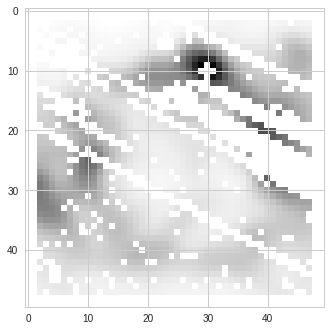

In [42]:
plt.imshow(np.reshape(lori_df['A9'].values,(50,50)))

In [43]:
np.isnan(lori_df_mask['mask'].iloc[6])

True

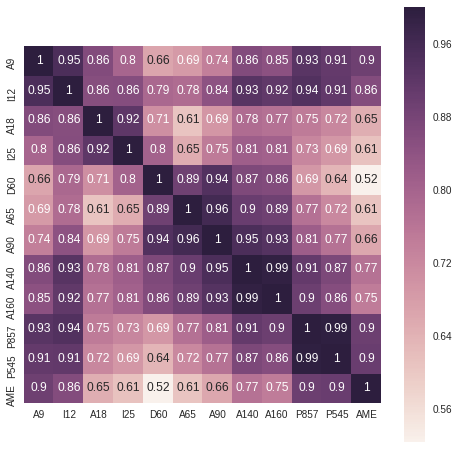

In [44]:
import seaborn as sb
plt.figure(figsize=(8,8))
sb.heatmap(lori_df.corr(method='spearman'), 
           annot=True,
          square=True)

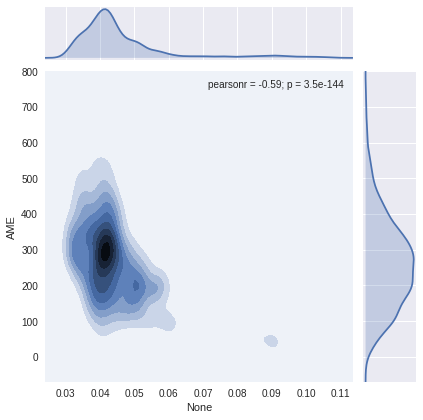

In [37]:
sb.jointplot(lori_df.iras25.divide(lori_df.akari140,axis=0), lori_df['AME'], kind= "kde")

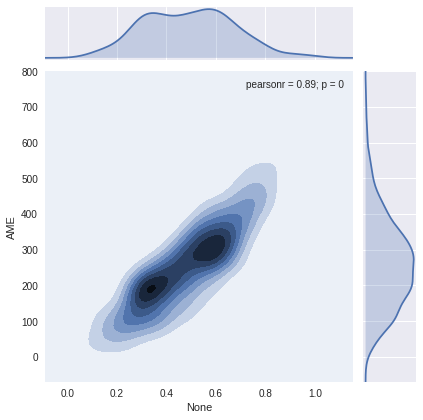

In [38]:
sb.jointplot(lori_df.akari9.divide(lori_df.iras12,axis=0), lori_df['AME'], kind= "kde")

TypeError: 'str' object is not callable

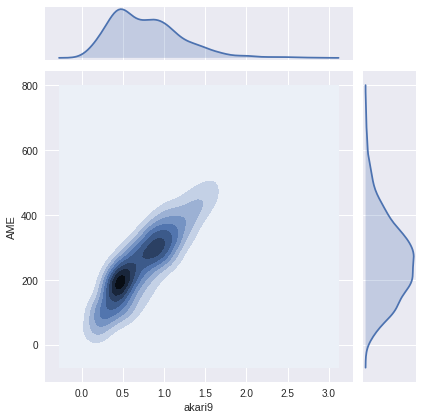

In [41]:
sb.jointplot(lori_df.akari9, lori_df['AME'], kind= "kde")

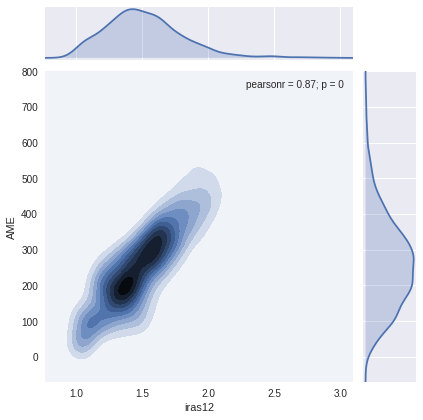

In [40]:
sb.jointplot(lori_df.iras12, lori_df['AME'], kind= "kde")